In [1]:
%matplotlib inline
from matplotlib import pylab as plt

import ase
from ase.io import read
from ase.visualize import view
import numpy as np

from rascal.representations import SphericalInvariants
from rascal.models import gaptools
from rascal.models.asemd import ASEMLCalculator
from rascal.utils import dump_obj, load_obj, print_score
from rascal.models import gaptools, KRR

from tools.download import download_url
from tools.utils import fix_frames, train_test_split, filter_frames, get_config_type, draw_dimer_curve
from tools.radial_basis import draw_radial_basis

For this exercise we will use the [Silicon dataset](https://doi.org/10.1103/PhysRevX.8.041048) published with

```
Machine Learning a General-Purpose Interatomic Potential for Silicon
Albert P. Bartók, James Kermode, Noam Bernstein, and Gábor Csányi
Phys. Rev. X 8, 041048 – Published 14 December 2018
```

In [2]:
# path to the dataset
url = "https://github.com/libAtoms/silicon-testing-framework/raw/master/models/GAP/gp_iter6_sparse9k.xml.xyz"

structures_fn = download_url(url, './')
structures_fn

Using existing file gp_iter6_sparse9k.xml.xyz


'./gp_iter6_sparse9k.xml.xyz'

# Build a SOAP-GAP Force Field for Silicon

The energy $E(A)$ of structure $A$ is modeled by an isolated atom contribution, i.e. $E_0(A)$, and the GAP model based on the SOAP featurization:

$$
                    E(A) = E_0(A) + \sum_{i\in A} \sum_{m=1}^M \alpha_m K(\bf{\mathbf{p}^{(i)}} , \mathbf{p}^{(m)} ).                   
$$

The isolated contribution is given by the energy of a silicon atom in vaccum. In this dataset, it corresponds to the 1$^{st}$ configuration.

In [72]:
# load the structures
frames = fix_frames(read(structures_fn,':'))
# and extract the first one because it coresponds to an isolated configuration
# used to convert total energies into formation energies
isolated_atom = frames[0]
frames = frames[1:]

global_species = [14]

# Isolated atom contributions
energy_baseline = {
    14: isolated_atom.info['dft_energy'],
}

The dataset is composed a several types of configurations. The solid phases, such as *bcc*, *diamond*, ..., represented but also configurations corresponding to *liquid*, *surfaces*, *vacancies*...

In [4]:
print(get_config_type(frames))

{'bt', 'decohesion', 'surface_111_3x3_das', 'crack_110_1-10', 'amorph', 'fcc', 'dia', 'screw_disloc', 'divacancy', 'sh', 'liq', 'surface_111', 'sp', '111adatom', 'bc8', 'bcc', 'crack_111_1-10', 'interstitial', 'sp2', 'surface_001', 'surface_110', 'vacancy', 'hcp', 'st12', 'hex_diamond', 'surface_111_pandey'}


Let's just build a model for the *diamond* and $\beta-S_n$ phases because it's simple to check its accuracy and also to lower the hardware requirements of this excercice.

In [5]:
excludes = [
    'amorph', 'crack_110_1-10', 'crack_111_1-10', 'decohesion', 'interstitial','divacancy', 'liq', 'screw_disloc','surface_001', 'surface_110', 'surface_111', 'surface_111_3x3_das', 'surface_111_pandey', 'vacancy', 'st12', '111adatom', 'bc8', 'hex_diamond', 'sh', 'sp2', 'sp', 'hcp', 'fcc', 'bcc',
]


excludes = []

# remove some types of configurations
frames = filter_frames(frames, excludes)
# Total number of structure to load
N = len(frames)
# Number of structure to train the model with
n_train = int(0.8*N)

print(get_config_type(frames))
N, n_train

{'bt', 'decohesion', 'surface_111_3x3_das', 'crack_110_1-10', 'amorph', 'fcc', 'dia', 'screw_disloc', 'divacancy', 'sh', 'liq', 'surface_111', 'sp', '111adatom', 'bc8', 'bcc', 'crack_111_1-10', 'interstitial', 'sp2', 'surface_001', 'surface_110', 'vacancy', 'hcp', 'st12', 'hex_diamond', 'surface_111_pandey'}


(2474, 1979)

Split the structures into a training and a test set. This is the most basic procedure to estimate the accuracy of the resulting model. 

In [6]:
ids = np.arange(N)
np.random.seed(19582)
np.random.shuffle(ids)

frames_train, y_train, f_train, frames_test, y_test, f_test = train_test_split(ids, n_train, frames)

Choose the parameter of the SOAP Power Spectrum. 

A *good* physical intuition of the system can simplify significantly the determination of an accurate model.

In [7]:
hypers = dict(soap_type="PowerSpectrum",
              # MAIN PARAMETERS OF of the SOAP REPRESENTATION
              # length of the spherical cutoff
              interaction_cutoff=5, 
              # size of the radial basis expension
              max_radial=8, 
              # size+1 of the spherical harmonics expension
              max_angular=6, 
              # width of the gaussian smearing
              gaussian_sigma_constant=0.4,
            
              # type of radial basis function
              radial_basis="GTO",
              # SECONDARY PARAMETERS
              cutoff_smooth_width=0.5,
              gaussian_sigma_type="Constant",
              normalize=True,
              compute_gradients=False,
              expansion_by_species_method='structure wise',
              optimization={"Spline":{"accuracy":1e-6}}
              )

soap = SphericalInvariants(**hypers)


Radial distribution function of the silicon dataset

![](images/rdf.png)

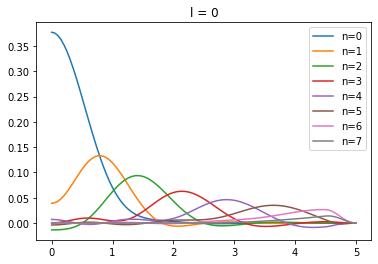

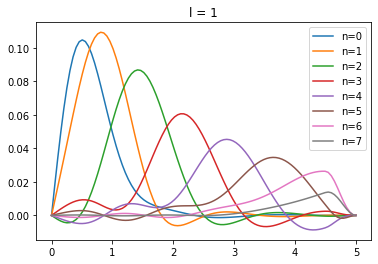

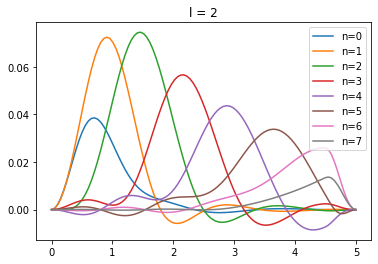

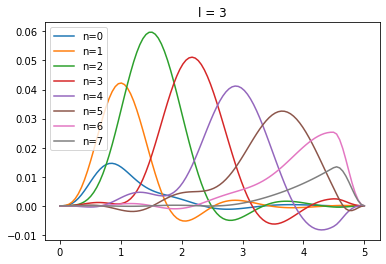

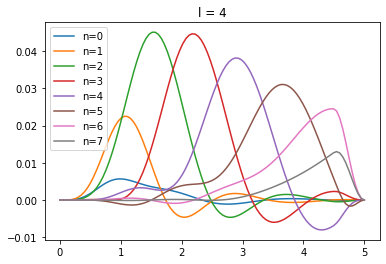

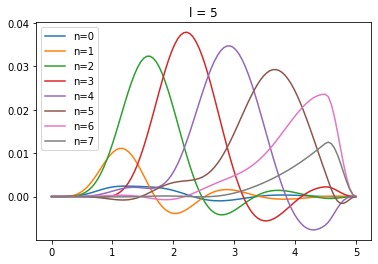

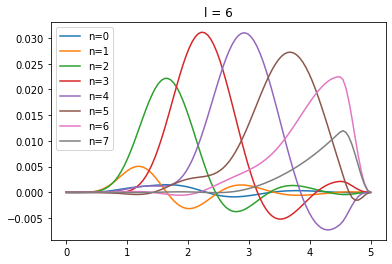

In [11]:
draw_radial_basis()

The GAP model is composed of two equally important ingredients:

+ the model's weights $\alpha_m$

+ the sparse points used as a basis for the regression

## Find the Sparce Points

A typical strategy to determine the sparse points is to select them directly from the dataset in an unsupervised fashion. 

Among the many possible unsupervised ML algorithms, we will use [Farthest Point Sampling](doi.org/10.1063/1.5024611) (FPS) because it is both quite effective and it has a small computational cost (in our current scenario).

The FPS algorithm applied to samples drawn from a double well distribution will select the orange data points:  

<img src="images/fps_double_well.png" width="400" height="400"/>


In addition to select "representative" local environment to use as sparse points, this algorithm can be used to select the set of most diverse features in order to lower the computational cost associated with the computation of the power spectrum and the dot product in the kernel computations:
$$
    k(\mathbf{p}^{(i)},\mathbf{p}^{(m)}) = \left[\frac{\mathbf{p}^{(i)} \cdot \mathbf{p}^{(m)}}{\|\mathbf{p}^{(i)}\| \| \mathbf{p}^{(m)}\|} \right]^{\zeta}
$$

This feature sparcification procedure has been shown to be quite effective at reducing the number of feature whithout affecting the overall accuracy of the resulting model.

In [8]:
# Compute the representation of all the structures
soap, feature_list = gaptools.calculate_representation(frames, hypers)

In [9]:
# Select the 200 features that are most important in this dataset 
n_features = 200
sparcified_hypers = gaptools.sparsify_features(soap, feature_list, 
                                n_features, selection_type="FPS")

In [10]:
# Compute the sparsified representation
soap, feature_list = gaptools.calculate_representation(frames, sparcified_hypers)

In [11]:
# Identify 1000 representative local environement within the dataset 
# to use as basis in the GAP model 
n_sparse = {14: 1000}
X_sparse = gaptools.sparsify_environments(soap, feature_list, n_sparse, selection_type="FPS")

## Train the GAP model

After finding some sparse points to use in the GAP model, we can start to train it.
With **rascal**, it is done in two steps :

+ build the $K_{NM}$ matrix for the training dataset for training with energies and forces

+ minimize the least square problem  $\| \alpha \mathbf{K}- \mathbf{Y} \|$

We first build several matrices using $\zeta=4$:

+ $K_{MM}$, the similarity between sparse points
+ $K_{NM}$ or **K_full_spars**, the similarity between configurations' features and the sparse points
+ $K_{NM}$ or **K_grad_full_sparse**, the similarity between configurations' feature gradients and the sparse points
 
To avoid large memory consumptions the $K_{NM}$ matrix is built one configuration at a time.


In [12]:
# Compute the kernel elements and their derivatives
(k_obj, K_sparse_sparse, K_full_sparse, K_grad_full_sparse) = gaptools.compute_kernels(
    soap,
    feature_list,
    X_sparse,
    soap_power=4,
)

Compute kernel gradients:   0%|          | 0/2474 [00:00<?, ?it/s]

Split the kernel matrices into a trainig and testing set

In [13]:
natoms = [len(frame) for frame in frames]
K_train_sparse, K_grad_train_sparse = gaptools.extract_kernel_indices(
    ids[:n_train], K_full_sparse, K_grad_full_sparse, natoms=natoms
)
K_test_sparse, K_grad_test_sparse = gaptools.extract_kernel_indices(
    ids[n_train:], K_full_sparse, K_grad_full_sparse, natoms=natoms
)

The direct linear system that solves the minimization problem
$$
\mathbf{\alpha}  = \mathbf{K}^{-1}\mathbf{Y},
$$
where
$$
\mathbf{K} = \mathbf{K}_{MM} + \mathbf{K}_{MN} \mathbf{\Lambda}^{-2} \mathbf{K}_{NM},
$$
and
$$
\mathbf{Y} =   \mathbf{K}_{MN} \mathbf{\Lambda}^{-2} \mathbf{y},
$$

is often ill-conditioned (mostly because of the $\mathbf{K}_{MN} \mathbf{\Lambda}^{-2} \mathbf{K}_{NM}$ product).

So to avoid numerical instabilities, the **"RKHS-QR"** method solves equivalently the minimization problem like this 
$$ 
\alpha = K_{MM}^{-1/2} \begin{bmatrix}K_{NM} K_{MM}^{-1/2}\\ \Lambda^{-1}\end{bmatrix}^{-1} \begin{bmatrix}\mathbf{Y}\\ \vec{0}\end{bmatrix}.$$

In [14]:
# train a gap model
weights = gaptools.fit_gap_simple(
    frames_train,
    K_sparse_sparse,
    y_train,
    K_train_sparse,
    energy_regularizer_peratom=1E-3,
    forces=f_train,
    kernel_gradients_sparse=K_grad_train_sparse,
    energy_atom_contributions=energy_baseline,
    force_regularizer=1E-2,
    solver="RKHS-QR"
)

In [15]:
model = KRR(weights, k_obj, X_sparse, energy_baseline,
            description="GAP MLIP for solid Silicon")
dump_obj('./models/silicon_model_full_dataset.json', model)

## Test the model

The quality of the trained model has to be checked using several metrics.

In [16]:
# you can load the previously trained model
model = load_obj('./models/silicon_model_small_dataset.json')

### on a test set

The simplest metric that can be used in all scenarios is to compute the error done on a test set. This estimate is most meaninful if the test set is representative of the inputs that will be seen during production, e.g. molecular dynamics simulation.

Error statistics on the energy per atom:
MAE=4.79e-03 RMSE=1.16e-02 SUP=1.80e-01 R2=1.00e+00 CORR=9.99e-01


Text(0, 0.5, 'reference energies [eV/atom]')

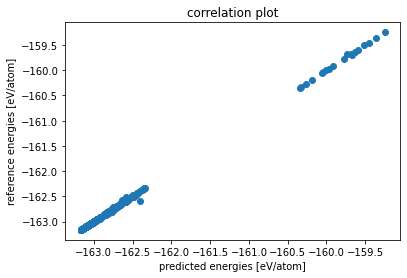

In [17]:
# basic assessement of the quality of the trained model
y_pred = model.predict(frames_test, KNM=K_test_sparse)
f_pred = model.predict_forces(frames_test, KNM=K_grad_test_sparse)
natoms = np.array([len(frame) for frame in frames_test])

print('Error statistics on the energy per atom:')
print_score(y_pred/natoms, y_test/natoms)
plt.plot(y_test/natoms, y_pred/natoms, 'o')
plt.title("correlation plot")
plt.xlabel("predicted energies [eV/atom]")
plt.ylabel("reference energies [eV/atom]")

Error statistics on the forces:
MAE=7.24e-02 RMSE=1.14e-01 SUP=1.78e+00 R2=9.77e-01 CORR=9.63e-01


Text(0, 0.5, 'reference forces [eV/$\\AA$]')

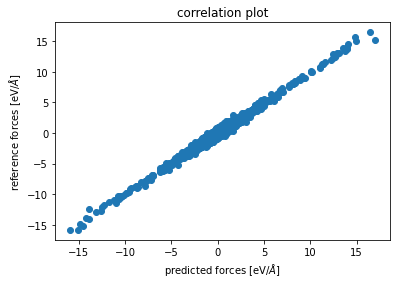

In [18]:
print('Error statistics on the forces:')
print_score(f_pred.flatten(), f_test.flatten())
plt.plot(f_pred.flatten(), f_test.flatten(), 'o')
plt.title("correlation plot")
plt.xlabel(r"predicted forces [eV/$\AA$]")
plt.ylabel(r"reference forces [eV/$\AA$]")

## Using KFold Cross Validation

Illustration of k-fold cross-validation when n = 12 observations and k = 3. After data is shuffled, a total of 3 models will be trained and tested.

![](images/KfoldCV.gif)



[By MBanuelos22 - Own work, CC BY-SA 4.0](https://commons.wikimedia.org/w/index.php?curid=87684542)

### On physical properties: 

+ Equation of State (EoS) of the diamond and $\beta$-$S_n$ phases of silicon 

+ elastic tensor of the diamond phase

In [19]:
from rascal.models.asemd import ASEMLCalculator

from tools.lattice_cubic import do_lattice as do_cubic
from tools.lattice_tetragonal import do_lattice as do_tetragonal
from tools.utils import dft_ref

from ase.io.trajectory import Trajectory
from ase.io import read
from ase.lattice.cubic import Diamond



#### The diamond phase

In [20]:
calc = ASEMLCalculator(model, model.get_representation_calculator())
a0 = (20.0*8)**(1.0/3.0) # initial guess at lattice constant, cell will be relaxed below

# set up the a
atoms = Diamond(symbol='Si', latticeconstant=a0)
atoms.set_calculator(calc)
c11, c12, c44, E_vs_V = do_cubic(atoms, elastic=True)
a0 = atoms.cell[0,0] # save lattice constant after relaxation

/home/musil/miniconda/envs/mlip_workshop/lib/python3.9/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.reciprocal()
  warnings.warn(warning)


Fitting C_11
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-3.0950506 , -1.49704258, -0.01324399,  1.33396822,  2.65693789]) GPa
Cij (gradient) / GPa    :     143.34987773061349
Error in Cij / GPa      :     3.4033170019948034
Correlation coefficient :     0.999155594487299
Setting C11 (1) to 0.894720 +/- 0.021242


Fitting C_21
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-1.19253681, -0.55220888, -0.01324399,  0.43432108,  0.84372776]) GPa
Cij (gradient) / GPa    :     50.59059107317303
Error in Cij / GPa      :     2.7257346112280447
Correlation coefficient :     0.9956739296936551
Setting C21 (7) to 0.315762 +/- 0.017013


Fitting C_31
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-1.19253681, -0.55220888, -0.01324399,  0.43432108,  0.84372776]) GPa
Cij (gradient) / GPa    :     50.59059107317309
Error in Cij / GPa      :     2.7257346112279066
Correlation coefficient :     0.9956739296936555
Updating C31 (7) with value 0.31576

In [21]:
ml_pred = {}
ml_pred['diamond'] = {'a0': a0, 'c11': c11, 'c12': c12, 'c44': c44, 
                  'bulk_modulus': (c11+2.0*c12)/3.0, 'E_vs_V': E_vs_V }

#### The $\beta$-$S_n$ phase

In [39]:
atoms = ase.Atoms([14] * 2, positions=[(0.0, -0.25, -0.069), (0.0, 0.25, 0.069)], 
       cell=[ [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.5, 0.5, 0.276]], pbc=(1,1,1))

cell = atoms.get_cell()
cell *= (20.0*2/atoms.get_volume())**(1.0/3.0)
atoms.set_cell(cell, scale_atoms=True)
atoms.set_calculator(calc)

E_vs_V = do_tetragonal(atoms, elastic=False)

# dictionary of computed properties - this is output of this test, to
#   be compared with other models
ml_pred['beta-Sn'] = {'E_vs_V': E_vs_V }

#### Compare our MLIP with the DFT reference

In [22]:
print('Relative error on several structural properties of the diamond phase of silicon w.r.t. the DFT reference:')
for (k,ref) in dft_ref['diamond'].items():
    pred = ml_pred['diamond'][k]
    if k == 'E_vs_V': continue
    print(f"    {k}: {(ref-pred)/ref*100} %")

Relative error on several structural properties of the diamond phase of silicon w.r.t. the DFT reference:
    bulk_modulus: 7.9984284301345605 %
    c12: 10.061315327365502 %
    c11: 6.484466113514191 %
    c44: 20.30045127367782 %
    a0: 0.13134699775994252 %


Relative error on several structural properties of the diamond phase of silicon w.r.t. the DFT reference:
    bulk_modulus: 0.450277747495 %
    c12: -6.672964621025444 %
    c11: 5.678058549520227 %
    c44: 14.340839542118875 %
    a0: 0.008301429446369893 %

KeyError: 'beta-Sn'

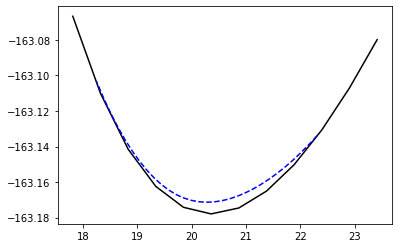

In [24]:
aa = np.array(dft_ref['diamond']['E_vs_V'],dtype=object)
bb = np.array(ml_pred['diamond']['E_vs_V'],dtype=object)
plt.plot(aa[:,0],aa[:,1],'-k',label='diamond ref')
plt.plot(bb[:,0],bb[:,1],'--b',label='diamond pred')

aa = np.array(dft_ref['beta-Sn']['E_vs_V'],dtype=object)
bb = np.array(ml_pred['beta-Sn']['E_vs_V'],dtype=object)
plt.plot(aa[:,0],aa[:,1],'-k',label=r'$\beta-S_n$ ref')
plt.plot(bb[:,0],bb[:,1],'--r',label=r'$\beta-S_n$ pred')
plt.title('Equation of State')
plt.ylabel('Energy [eV]')
plt.xlabel(r'Volume [$\AA^3$]')
plt.legend()

### On dimer curve

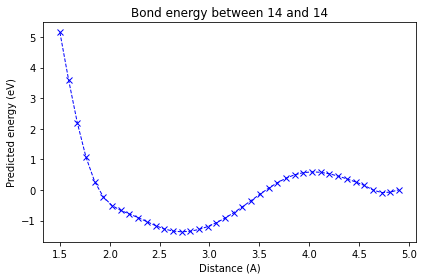

In [28]:
draw_dimer_curve(model, lim=(1.5, 4.9))

In [29]:
# load a model on the full dataset
model = load_obj('./models/silicon_model_full_dataset.json')

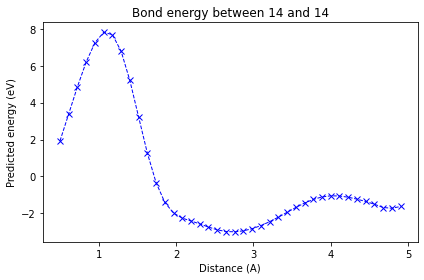

In [31]:
draw_dimer_curve(model, lim=(.5, 4.9))

# Use it to run a MD simulation

In [103]:
from ase.md import MDLogger
from ase.md.langevin import Langevin
from ase import units
from ase.io.trajectory import Trajectory
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution

In [113]:
from rascal.models.asemd import ASEMLCalculator

In [105]:
# Use the model loaded above
soap = model.get_representation_calculator()
calc = ASEMLCalculator(model, soap)

In [106]:
log_fn = '/tmp/md.log'
filename = '/tmp/md.traj'

T = 500

In [109]:
%%time

atoms = read(structures_fn, 50)

MaxwellBoltzmannDistribution(atoms, T* units.kB)

atoms.set_calculator(calc)

traj = Trajectory(filename, mode='w', atoms=atoms, master=None)

dyn = Langevin(atoms, 0.5 * units.fs, temperature_K= T, friction=0.002)

dyn.attach(MDLogger(dyn, atoms, log_fn, header=True, stress=False,
           peratom=False, mode="w"), interval=50)

dyn.attach(traj.write, interval=10)

dyn.run(1000)

/home/musil/miniconda/envs/mlip_workshop/lib/python3.9/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


CPU times: user 6min 56s, sys: 19min 29s, total: 26min 25s
Wall time: 1min 39s


True

Uncomment and run the cell below to examine the trajectory using the ASE viewer:

In [110]:
view(read(filename,':'), viewer='ngl')